<a href="https://colab.research.google.com/github/DaverArenas/procesamientoSe-alesInteligenciaArtificial/blob/main/Clase7E1_PyCaret_24_09_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de series de tiempo con PyCaret



``` pycaret``` es una librería de código abierto que facilita el análisis de diferentes modelos de ML. En el link [pycaret](https://https://pycaret.gitbook.io/docs/) puedes revisar las funcionalidades y más ejemplos del uso de la librería

En particular utilizaremos el módulo de regresión, con el fin de estimar las relaciones entre una variable dependientes y una o más variables independeintes. 
Todos los módulos de PyCaret cuentan con funciones de preprocesamieto para preparar los datos para el modelado. 

En este ejemplo utilizaremos el conjutno de datos de pasajeros de aerolineas de EE.UU. Este dataset proporciona el total de pasajeor mensuales en las aerolineas desde 1949 hasta 1960

In [1]:
!pip install pycaret
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 2.3 MB/s 
     |████████████████████████████████| 25.9 MB 1.4 MB/s 
     |████████████████████████████████| 56 kB 3.4 MB/s 
     |████████████████████████████████| 268 kB 28.2 MB/s 
     |████████████████████████████████| 2.0 MB 12.8 MB/s 
     |████████████████████████████████| 88 kB 6.8 MB/s 
     |████████████████████████████████| 6.8 MB 30.4 MB/s 
     |████████████████████████████████| 167 kB 38.9 MB/s 
     |████████████████████████████████| 1.3 MB 18.4 MB/s 
     |████████████████████████████████| 1.7 MB 22.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 636 kB 51.3 MB/s 
     |████████████████████████████████| 16.9 MB 1.1 MB/s 
     |████████████████████████████████| 3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pycaret.utils import enable_colab
enable_colab

<function pycaret.utils.enable_colab()>

## Cargar los datos

In [3]:
import pandas as pd
import numpy as np
import jinja2
import plotly.express as px

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Especializacion BigData EIA/Procesamiento_Señales/Clase_7/AirPassengers.csv')

In [5]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
df['Date'] = pd.to_datetime(df['Month'])

In [8]:
df.head()

,Month,#Passengers,Date
0,1949-01,112,1949-01-01
1,1949-02,118,1949-02-01
2,1949-03,132,1949-03-01
3,1949-04,129,1949-04-01
4,1949-05,121,1949-05-01


In [7]:
df.drop(['Month'], axis = 1, inplace = True)
df.columns = df.columns.str.replace('#Passengers', 'Passengers')

df.head()

,Passengers,Date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01


Vamos a realizar un filtrado de media movil para 12 meses

In [8]:
#Realizamos un filtro de media movil con 12 meses para revisar la tendencia
window = 12
df['MA12'] = df['Passengers'].rolling(window).mean()

fig = px.line(df, x = 'Date', y = ['Passengers', 'MA12'], template = 'plotly_dark')
fig.show()

Dado que los algoritmos de ML no manejan directamente ls fechas, vamos a extreaer características simples de las fechas como el mes y el año, y vamos a eliminar la fecha original

In [9]:
#Separamos el año y mes en nuevas columnas
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df.drop(['MA12'], axis = 1, inplace = True)
df['Series'] = np.arange(1,len(df)+1)
df = df[['Series', 'Year', 'Month', 'Passengers', 'Date']] 
df.head()

,Series,Year,Month,Passengers,Date
0,1,1949,1,112,1949-01-01
1,2,1949,2,118,1949-02-01
2,3,1949,3,132,1949-03-01
3,4,1949,4,129,1949-04-01
4,5,1949,5,121,1949-05-01


Si tuviéramos horas podríamos sacar la columna de horas.

Ahora vamos a dividir el dataset, se puede pasar todo el dataset a PyCartet y se debe tener cuidado que en el parámetro `data_split_shuffle=False` para evitar que se desordenen los datos.




In [10]:
#Año max y min dentro del dataset
print(min(df['Year']),max(df['Year']))

1949 1960


In [11]:
#Debemos partir los datos manualmente para tener el train y test divididos de forma consecutiva, sin desordenarlo
train = df[df['Year'] < 1960]
test = df[df['Year'] >= 1960]

print(train.shape, test.shape)

(132, 5) (12, 5)


## Iniciar la configuración

Ahora vamos a pasar el dataset para inicializar la configuración, indicando explícitamente los datos de entrenamiento, los datos de prueba y la estrategia de validación 


In [15]:
#Debemos usar esta version para usar pycaret regresion
!pip install numpy==1.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 7.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.0 which is incompatible.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.
en-core-web-sm 3.4.0 requires spacy<3.5.0,>=3.4.0, but you have spacy 2.3.7 which is incompatible.
cmdstanpy 1.0.7 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.


In [12]:
#Importamos la libreria pycaret.regression
from pycaret.regression import *

fold es la forma de entrenamiento? cada 3 muestras

In [13]:
#Pasamos los datos de train y test. El target que vamos a predecir. Los datos numericos y la columna que vamos a ignorar. fold
s = setup(data = train, test_data = test, target = 'Passengers', 
          fold_strategy = 'timeseries', 
          numeric_features = ['Year', 'Series'], 
          ignore_features = ['Date'],
          fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Passengers
2,Original Data,"(132, 5)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(132, 13)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True,
                                      features_todrop=['Date'], id_columns=[],
                                      ml_usecase='regression',
                                      numerical_features=['Year', 'Series'],
                                      target='Passengers', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numeric...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
        

## Entrenar el modelo
Métricas de evaluación 
- mean absolute error (MAE)
- mean squared error (MSE)
- root mean squared error (RMSE)
- R-squared (R2) 
- Root Mean Squared Logaritmic Error (RMSLE)
- Mean Absolute Percentage Error (MAPE) 

In [14]:
#Comparacion de todos los modelos que me permiten hacer una regresion para determinar el mejor modelo que se ajusta a mis datos. Ordenamos por el error absoluto medio
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lar,Least Angle Regression,22.3980,923.8654,28.2855,0.5621,0.0878,0.0746,0.0567
lr,Linear Regression,22.3981,923.8747,28.2856,0.5621,0.0878,0.0746,1.3933
huber,Huber Regressor,22.4166,891.5125,27.9332,0.5989,0.0879,0.0749,0.0467
br,Bayesian Ridge,22.4783,932.2165,28.5483,0.5611,0.0884,0.0746,0.0433
ridge,Ridge Regression,23.1976,1003.9423,30.0409,0.5258,0.0933,0.0764,0.0267
lasso,Lasso Regression,38.4188,2413.5096,46.8468,0.0882,0.1473,0.1241,0.0233
en,Elastic Net,40.6486,2618.8753,49.4048,-0.0824,0.1563,0.1349,0.0267
omp,Orthogonal Matching Pursuit,44.3054,3048.2658,53.8613,-0.4499,0.1713,0.1520,0.0267
gbr,Gradient Boosting Regressor,50.1217,4032.0567,61.2306,-0.6189,0.2034,0.1538,0.0533
rf,Random Forest Regressor,52.7754,4705.6863,65.6728,-0.7962,0.2148,0.1592,0.2700


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(copy_X=True, eps=2.220446049250313e-16,
                                fit_intercept=True, fit_path=True, jitter=None,
                                n_nonzero_coefs=500, normalize=True,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                precompute='auto', random_state=123,
                                regressor=Lars(copy_X=True,
                                               eps=2.220446049250313e-16,
                                               fit_intercept=True,
                                               fit_path=True, jitter=None,
                                               n_nonzero_coefs=500,
                                               normalize=True,
                                               preco

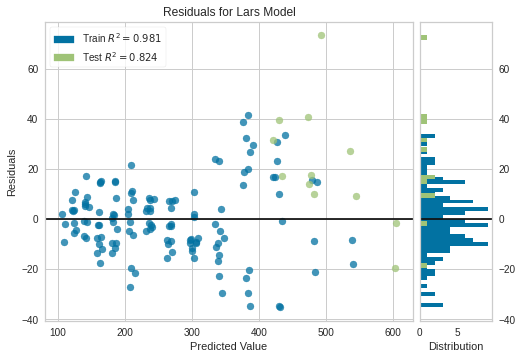

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [15]:
plot_model(best, plot = 'residuals')

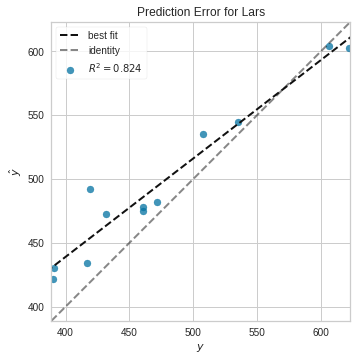

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [16]:
plot_model(best, plot = 'error')

## Predicción del modelo sobre todos los datos
Generar la predicción sobre los datos originales, en la gráfica sombreamos los datos de prueba, es decir el ultimo año 

In [17]:
predictions = predict_model(best, data=df)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PowerTransformedTargetRegressor(copy_X=True, eps=2.220446049250313e-16,
                                fit_intercept=True, fit_path=True, jitter=None,
                                n_nonzero_coefs=500, normalize=True,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                precompute='auto', random_state=123,
                                regressor=Lars(copy_X=True,
                                               eps=2.220446049250313e-16,
                                               fit_intercept=True,
                                               fit_path=True, jitter=None,
                                               n_nonzero_coefs=500,
                                               normalize=True,
                                               precompute='auto',
                            

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,12.5381,278.7548,16.696,0.9805,0.0538,0.0447


In [18]:
predictions

,Series,Year,Month,Passengers,Date,Label
0,1,1949,1,112,1949-01-01,109.884005
1,2,1949,2,118,1949-02-01,108.770836
2,3,1949,3,132,1949-03-01,127.663380
3,4,1949,4,129,1949-04-01,123.391017
4,5,1949,5,121,1949-05-01,124.432494
...,...,...,...,...,...,...
139,140,1960,8,606,1960-08-01,604.306269
140,141,1960,9,508,1960-09-01,535.280111
141,142,1960,10,461,1960-10-01,474.989781
142,143,1960,11,390,1960-11-01,421.695133


In [19]:
fig = px.line(predictions, x='Date', y=["Passengers", "Label"], template = 'plotly_dark')
fig.add_vrect(x0="1960-01-01", x1="1960-12-01", fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

# Construyendo modelo final

Después de entrenar el modelo vamos a predecir para los siguientes 5 años. 

In [20]:
#Esta función nos permite establecer el modelo final para hacer predicciones a mas tiempo
final_best = finalize_model(best)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=PowerTransformedTargetRegressor(copy_X=True, eps=2.220446049250313e-16,
                                fit_intercept=True, fit_path=True, jitter=None,
                                n_nonzero_coefs=500, normalize=True,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                precompute='auto', random_state=123,
                                regressor=Lars(copy_X=True,
                                               eps=2.220446049250313e-16,
                                               fit_intercept=True,
                                               fit_path=True, jitter=None,
                                               n_nonzero_coefs=500,
                                               normalize=True,
                                               precompute='auto',
                          

## Predicción del modelo

In [21]:
#Creamos un nuevo dataframe con nuevos datos para validar el modelo, vamos a predecir 5 años. Con distribución de datos mensual
future_dates = pd.date_range(start = '1961-01-01', end = '1965-01-01', freq = 'MS')
future_df = pd.DataFrame()
future_df['Month'] = [i.month for i in future_dates]
future_df['Year'] = [i.year for i in future_dates]    
future_df['Series'] = np.arange(145,(145+len(future_dates)))
future_df.head()

,Month,Year,Series
0,1,1961,145
1,2,1961,146
2,3,1961,147
3,4,1961,148
4,5,1961,149


In [22]:
#Vamos a predecir loss nuevos valores
predictions_future = predict_model(final_best, data=future_df)
predictions_future.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PowerTransformedTargetRegressor(copy_X=True, eps=2.220446049250313e-16,
                                fit_intercept=True, fit_path=True, jitter=None,
                                n_nonzero_coefs=500, normalize=True,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                precompute='auto', random_state=123,
                                regressor=Lars(copy_X=True,
                                               eps=2.220446049250313e-16,
                                               fit_intercept=True,
                                               fit_path=True, jitter=None,
                                               n_nonzero_coefs=500,
                                               normalize=True,
                                               precompute='auto',
                            

,Month,Year,Series,Label
0,1,1961,145,486.278268
1,2,1961,146,482.208187
2,3,1961,147,550.485967
3,4,1961,148,535.187177
4,5,1961,149,538.923789


In [23]:
#Plotiamos las nuevas predicciones
concat_df = pd.concat([df,predictions_future], axis=0)
concat_df_i = pd.date_range(start='1949-01-01', end = '1965-01-01', freq = 'MS')
concat_df.set_index(concat_df_i, inplace=True)
fig = px.line(concat_df, x=concat_df.index, y=["Passengers", "Label"], template = 'plotly_dark')
fig.show()